# TALLER 9: Large Lenguage Models (LLMs)

## Instalando librerías 📦

Subir el archivo requirements.txt a google colab y ejecutar el siguiente comando

In [4]:
!pip install -qr requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.9/309.9 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.7/817.7 kB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 525.5/525.5 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.9/215.9 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.1/117.1 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.3/383.3 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

## Descripción de la aplicación 📖

Este laboratorio se centra en el uso de [Lang Chain](https://python.langchain.com/docs/get_started/introduction), [Pinecone](https://www.pinecone.io/) y [OpenAI](https://openai.com/) para desarrollar los siguientes desafíos:

In [5]:
import os

os.environ["OPENAI_API_KEY"] = "YOUR_OPENAI_API_KEY"
os.environ["PINECONE_API_KEY"] = "YOUR_PINECONE_API_KEY"
os.environ["PINECONE_ENV"] = "gcp-starter"

### Enviar solicitudes a Chatgpt y recuperar respuestas

Se utiliza la biblioteca Lang Chain para interactuar con OpenAI y enviar las solicitudes a Chatgpt. Se configura un modelo de lenguaje de aprendizaje profundo (LLM) de OpenAI para generar respuestas a partir de las solicitudes enviadas.

In [6]:
from langchain.chains import LLMChain
#from langchain.llms import OpenAI
from langchain_community.llms import OpenAI
from langchain.prompts import PromptTemplate



template = """Question: {question}

Answer: Let's think step by step."""

prompt = PromptTemplate(template=template, input_variables=["question"])

llm = OpenAI()

llm_chain = LLMChain(prompt=prompt, llm=llm)

question = "What is at the core of Popper's theory of science?"

response = llm_chain.run(question)
print(response)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.llms.openai.OpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAI`.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(




At the core of Popper's theory of science is the idea of falsifiability. This means that in order for a scientific theory to be considered valid, it must be able to be proven wrong or falsified through empirical evidence. This is in contrast to earlier theories of science, such as induction, which suggested that a theory could be proven true through repeated observations.

Popper also emphasized the importance of making bold and testable predictions in scientific research. He believed that the more risky a prediction, the more valuable it is in supporting or refuting a theory.

Another key aspect of Popper's theory is the concept of falsifiability as a demarcation criterion. This means that a theory or idea is only considered scientific if it can be falsified, and ideas that cannot be falsified, such as those based on faith or belief, are considered unscientific.

Additionally, Popper argued that scientific progress is not made through the accumulation of evidence in support of a the

### Escribir un RAG simple utilizando una base de datos de vectores en memoria

Creación de un Recuperador de Respuestas Generativas (RAG) simple utilizando una base de datos de vectores en memoria para almacenar y recuperar información relevante para responder a preguntas.

In [7]:
import bs4
from langchain import hub
from langchain_community.chat_models import ChatOpenAI
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.embeddings import OpenAIEmbeddings
from langchain.schema import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma

loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)

docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
print(splits[0])
print(splits[1])

vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings())
retriever = vectorstore.as_retriever()

prompt = hub.pull("rlm/rag-prompt")
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

response = rag_chain.invoke("What is Task Decomposition?")

print(response)

page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory' 

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.embeddings.openai.OpenAIEmbeddings` was deprecated in langchain-community 0.0.9 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.openai.ChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


Task Decomposition is a technique used to break down complex tasks into smaller and simpler steps. This approach helps agents to plan and execute tasks more efficiently by dividing them into manageable subgoals. Task decomposition can be achieved through various methods, such as using prompting techniques, task-specific instructions, or human inputs.


### Crear un RAG simple utilizando Pinecone


Creación de un Recuperador de Respuestas Generativas (RAG) simple utilizando Pinecone para almacenar y recuperar información relevante para responder a preguntas.

In [8]:
from langchain_community.document_loaders import TextLoader
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone, PodSpec

def loadText():
    loader = TextLoader("Conocimiento.txt")
    documents = loader.load()
    #text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size = 1000,
        chunk_overlap  = 200,
        length_function = len,
        is_separator_regex = False,
    )


    docs = text_splitter.split_documents(documents)

    embeddings = OpenAIEmbeddings()

    import pinecone


    index_name = "langchain-demo"
    pc = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))

    print(pc.list_indexes())

    # First, check if our index already exists. If it doesn't, we create it
    if len(pc.list_indexes())==0:
        # we create a new index
        #pc.create_index(name=index_name, metric="cosine", dimension=1536)
        pc.create_index(
            name=index_name,
            dimension=1536,
            metric="cosine",
            spec=PodSpec(
                environment=os.getenv("PINECONE_ENV"),
                pod_type="p1.x1",
                pods=1
            )
        )

    # The OpenAI embedding model `text-embedding-ada-002 uses 1536 dimensions`
    docsearch = PineconeVectorStore.from_documents(docs, embeddings, index_name=index_name)

loadText()

{'indexes': []}


Al cargar a pinecone nuestro texto de conocimiento nos arroja que seran transformados a vectores que luego ayudara para realizar preguntas

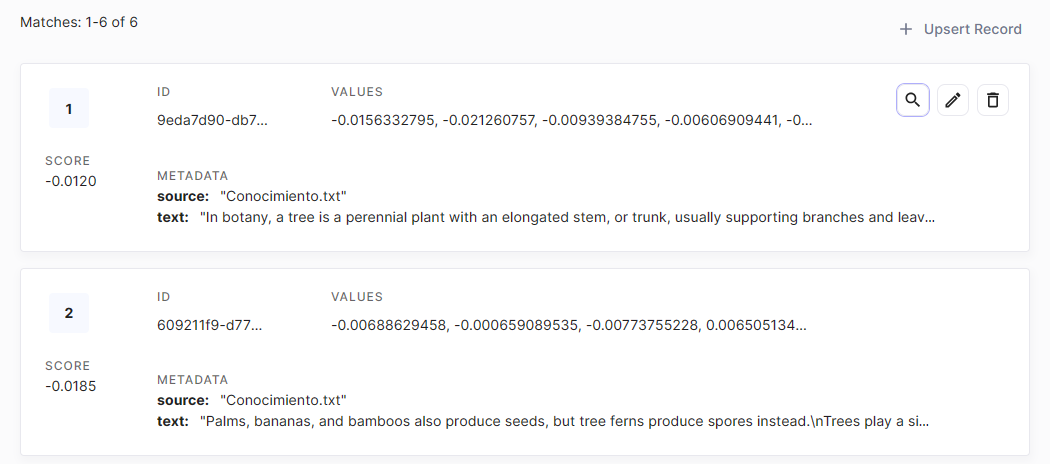

In [10]:
def search():
    embeddings = OpenAIEmbeddings()

    index_name = "langchain-demo"
    # if you already have an index, you can load it like this
    docsearch = PineconeVectorStore.from_existing_index(index_name, embeddings)

    query = "What is a tree?"
    docs = docsearch.similarity_search(query)

    print(docs[0].page_content)

search()

In botany, a tree is a perennial plant with an elongated stem, or trunk, usually supporting branches and leaves.
In some usages, the definition of a tree may be narrower, including only woody plants with secondary growth,
plants that are usable as lumber or plants above a specified height. In wider definitions, the taller palms, tree ferns, bananas, and bamboos are also trees.
Trees are not a monophyletic taxonomic group but consist of a wide variety of plant species that have independently evolved a trunk and branches as a way to tower above other plants to compete for sunlight.
The majority of tree species are angiosperms or hardwoods; of the rest, many are gymnosperms or softwoods.
Trees tend to be long-lived, some reaching several thousand years old. Trees have been in existence for 370 million years.
It is estimated that there are around three trillion mature trees in the world.


## Construido con 🛠️

- [Python](https://www.python.org/) - Lenguaje de programación.
- [Lang Chain](https://python.langchain.com/docs/get_started/introduction) - Biblioteca de Python para interactuar con OpenAI.
- [Pinecone](https://www.pinecone.io/) - Servicio de indexación y búsqueda de vectores.
- [OpenAI](https://openai.com/) - Plataforma de inteligencia artificial.

## Versionado 📌

  ![AREP LAB 09](https://img.shields.io/badge/AREP_LAB_09-v1.0.0-blue)

## Autores ✒️

- **Daniel Santanilla** - [ELS4NTA](https://github.com/ELS4NTA)

## Licencia 📄

[![License: MIT](https://img.shields.io/badge/License-MIT-yellow.svg)](https://opensource.org/licenses/MIT)

## Agradecimientos 🎁

- Al profesor [Luis Daniel Benavides Navarro](https://ldbn.is.escuelaing.edu.co/) por compartir sus conocimientos.
- Al monitor que revisó el laboratorio.